# import

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# function

In [96]:
def plot_scatter(split, fn, fp):
    val_path = "../kitt/DATA_progress3_new/{}/val/val.csv".format(split)
    val_data = pd.read_csv(val_path)
    train_path = "../kitt/DATA_progress3_new/{}/train/train_oversampling.csv".format(split)
    train_data = pd.read_csv(train_path)
    
    # false negative : truth=M predicted=B
    
    # col = ['texture_mean', 'area_mean', 'smoothness_mean',
    #    'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean',
    #    'texture_se', 'area_se', 'smoothness_se', 'concavity_se', 'symmetry_se',
    #    'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
    #    'symmetry_worst', 'fractal_dimension_worst']
    
    x_col = 'area_mean'
    y_col = 'area_se'
    
    # Get the false predictions data from the original data using the indices of false predictions
    fn = val_data.iloc[fn]
    fp = val_data.iloc[fp]
     
    # Get the true predictions data from the original data using the indices of true predictions
    benign_data = train_data[229:]
    malignant_data= train_data[:228]

    # Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
    plt.scatter(benign_data[x_col], benign_data[y_col], color='blue', label='True Negative', alpha=0.5)
    plt.scatter(malignant_data[x_col], malignant_data[y_col], color='green', label='True Positive', alpha=0.5)
    plt.scatter(fn[x_col], fn[y_col], color='yellow', label='False Negative')
    plt.scatter(fp[x_col], fp[y_col], color='red', label='False Positive')

    # Add legend and labels
    plt.legend()
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    # Show the plot
    plt.show()

In [97]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1

In [98]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3_new"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [99]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [100]:
def plot_cm(cm_val, save=False,which="-"):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title(which, fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [101]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [102]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [103]:
def evaluate(param,split):
    model_path = "../logisticregression/models/param{}/lr_model_{}.pkl".format(param,split)
    print(model_path)
    loaded_model = joblib.load(model_path)

    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm(cm_val, which="Validate set")
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm(cm_test,which="Test set")

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    
    coef(param,split)
    
    print("################# false predict ##################")
    fp = false_predict(y_val, y_pred_val, split)
    print(fp)
    
    return cm_val,cm_test,auc1,auc2

In [104]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [105]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

In [106]:
def false_predict(y_true, y_pred, split):
    """
    Compares two arrays and returns the indices of false predictions.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        The indices of false predictions.
    """
    path = "../kitt/DATA_progress3_new/"
    # test_path =  "{}/test.csv".format(path)
    # test_data = pd.read_csv(test_path)
    valid_path = "{}/{}/val/val.csv".format(path,split)
    val_data = pd.read_csv(valid_path)
    false_indices = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            false_indices.append(i)
    print(val_data.loc[false_indices])
    return false_indices

In [107]:
def coef(param,split):
    model_path = "../logisticregression/models/param5/lr_model_{}.pkl".format(param,split)
    loaded_model = joblib.load(model_path)
    path = "../kitt/DATA_progress3_new/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    train_data = pd.read_csv(train_path)
    x_train = train_data[train_data.columns[2:]]
    
    feature_coef = loaded_model.coef_

    # print the feature importance
    for i, coef in enumerate(feature_coef):
        coef_abs = np.abs(coef)
        df = pd.DataFrame({'Variable':x_train.columns,
              'Coef':coef_abs}).sort_values('Coef', ascending=False)
        
        print(df)

# Set up all split

In [108]:
def train_param1(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    model = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
    model.fit(x_train, y_train)
    joblib.dump(model, "../logisticregression/models/param5/lr_model_{}.pkl".format(split))

# Parameter1

## split1

In [109]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [110]:
train_param1(split)

../kitt/DATA_progress3_new/split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [111]:
# hello world!
#param = 5
#param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

## split2

In [112]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [113]:
train_param1(split)

../kitt/DATA_progress3_new/split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [114]:
#param = 5
#param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## split3

In [115]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [116]:
train_param1(split)

../kitt/DATA_progress3_new/split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [117]:
#param = 5
#param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## split4

In [118]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [119]:
train_param1(split)

../kitt/DATA_progress3_new/split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [120]:
#param = 5
#param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## split5

In [121]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [122]:
train_param1(split)

../kitt/DATA_progress3_new/split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3_new/test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3_new/split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


In [123]:
#param = 5
#param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

In [124]:
train_path = "../kitt/DATA_progress3_new/train.csv"
test_path = "../kitt/DATA_progress3_new/test.csv"

In [125]:
# Load the train set
train_data = pd.read_csv(train_path)
print(train_data.shape)
x_train = train_data[train_data.columns[2:]]
print(x_train.shape)
y_train = train_data[train_data.columns[1]]
le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
print(le.classes_)

# Load the test se
test_data = pd.read_csv(test_path)
print(test_data.shape)
x_test = test_data[test_data.columns[2:]]
print(x_test.shape)
y_test = test_data[test_data.columns[1]]
le = LabelEncoder()
y_test = np.array(le.fit_transform(y_test))
print(le.classes_)

# StandardScaler
sc = StandardScaler()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

(455, 18)
(455, 16)
['B' 'M']
(114, 18)
(114, 16)
['B' 'M']


In [126]:
model = LogisticRegression(C=0.08685113737513521, max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(x_train, y_train) # Save the trained model to disk
joblib.dump(model, "../logisticregression/models/lr_model_all.pkl")

['../logisticregression/models/lr_model_all.pkl']

../logisticregression/models/lr_model_all.pkl
################# test set ##################
Best Threshold=0.439639
FPR: 0.0000
TPR: 0.9524
Confusion Matrix
----------------
[[72  0]
 [ 2 40]] 

----------------
Sensitivity: 95.24%
Specificity: 100.00%
Accuracy: 98.25%
Precision: 100.00%
Sensitivity: 95.24%
Precision: 100.00%
F1: 97.56%


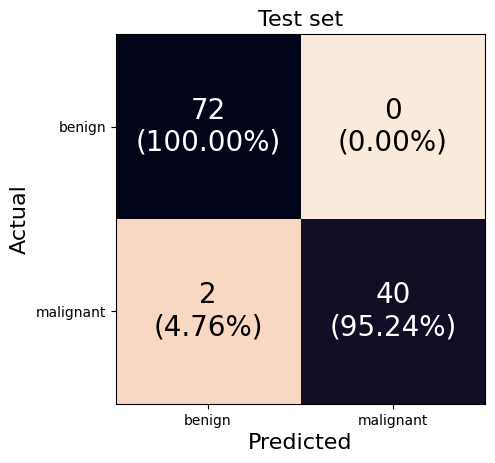

---------------------------------------
AUC test: 99.67%


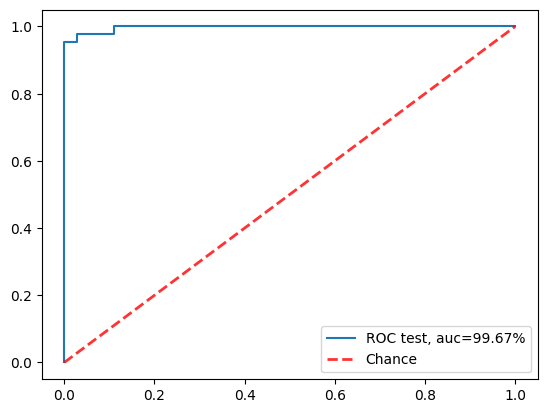

################# false predict ##################
         id diagnosis  texture_mean  area_mean  smoothness_mean   
94    87163         M         19.63      565.4          0.09048  \
110  889403         M         19.38      758.6          0.07840   

     concavity_mean  symmetry_mean  fractal_dimension_mean  texture_se   
94          0.05858         0.1598                 0.05671      1.1470  \
110         0.04209         0.1547                 0.05443      0.9988   

     area_se  smoothness_se  concavity_se  symmetry_se  fractal_dimension_se   
94     43.40       0.006003       0.02151      0.01520              0.001868  \
110    22.18       0.002826       0.01311      0.01013              0.001345   

     smoothness_worst  concavity_worst  symmetry_worst   
94             0.1401           0.2644          0.2884  \
110            0.1084           0.2260          0.2683   

     fractal_dimension_worst  
94                   0.07371  
110                  0.06829  
[94, 110]


In [127]:
model_path = "../logisticregression/models/lr_model_all.pkl"
print(model_path)
loaded_model = joblib.load(model_path)

# ################# test set ##################
label = ['benign','malignant']
print("################# test set ##################")
y_pred_test_raw = loaded_model.predict_proba(x_test)
y_pred_test = thresholding(y_test, y_pred_test_raw)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix')
print('-'*16)
print(cm_test,'\n')
print('-'*16)

# Calculate score
# print(split)
cal_score_all(cm_test)

# plot confusion matrix
plot_cm(cm_test,which="Test set")

################## plot ROC curve ########################
# fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
# auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
gmeans2 = np.sqrt(tpr2 * (1-fpr2))
ix2 = np.argmax(gmeans2)
print("---------------------------------------")
# print("AUC validate: %.2f%%" % auc1)
print("AUC test: %.2f%%" % auc2)
# plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

plt.legend(loc=4)
plt.show()


print("################# false predict ##################")

false_indices = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_test[i]:
        false_indices.append(i)
print(test_data.loc[false_indices])
print(false_indices)

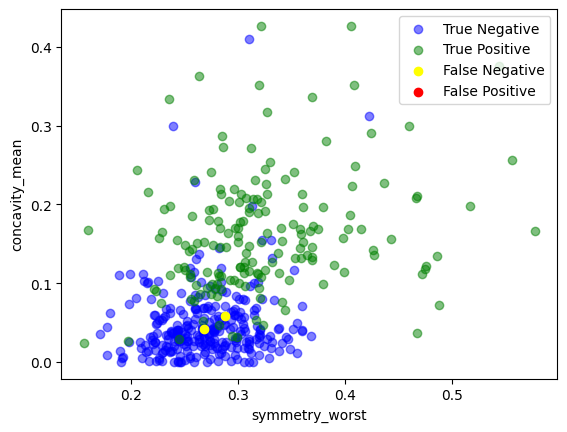

In [128]:
test_path = "../kitt/DATA_progress3_new/test.csv"
test_data = pd.read_csv(test_path)
train_path = "../kitt/DATA_progress3_new/train.csv"
train_data = pd.read_csv(train_path)

# false negative : truth=M predicted=B

# col = ['texture_mean', 'area_mean', 'smoothness_mean',
#    'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean',
#    'texture_se', 'area_se', 'smoothness_se', 'concavity_se', 'symmetry_se',
#    'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
#    'symmetry_worst', 'fractal_dimension_worst']

x_col = 'symmetry_worst'
y_col = 'concavity_mean'

fn = [94, 110]
fp = []

# Get the false predictions data from the original data using the indices of false predictions
fn = test_data.iloc[fn]
fp = test_data.iloc[fp]

# Get the true predictions data from the original data using the indices of true predictions
benign_data = train_data[train_data["diagnosis"] == 'B']
malignant_data= train_data[train_data["diagnosis"] == 'M']


# Create the scatter plot with false predictions data as red dots and true predictions data as blue dots
plt.scatter(benign_data[x_col], benign_data[y_col], color='blue', label='True Negative', alpha=0.5)
plt.scatter(malignant_data[x_col], malignant_data[y_col], color='green', label='True Positive', alpha=0.5)
plt.scatter(fn[x_col], fn[y_col], color='yellow', label='False Negative')
plt.scatter(fp[x_col], fp[y_col], color='red', label='False Positive')

# Add legend and labels
plt.legend()
plt.xlabel(x_col)
plt.ylabel(y_col)

# Show the plot
plt.show()